In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sn
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

import math
import pandas as pd


In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

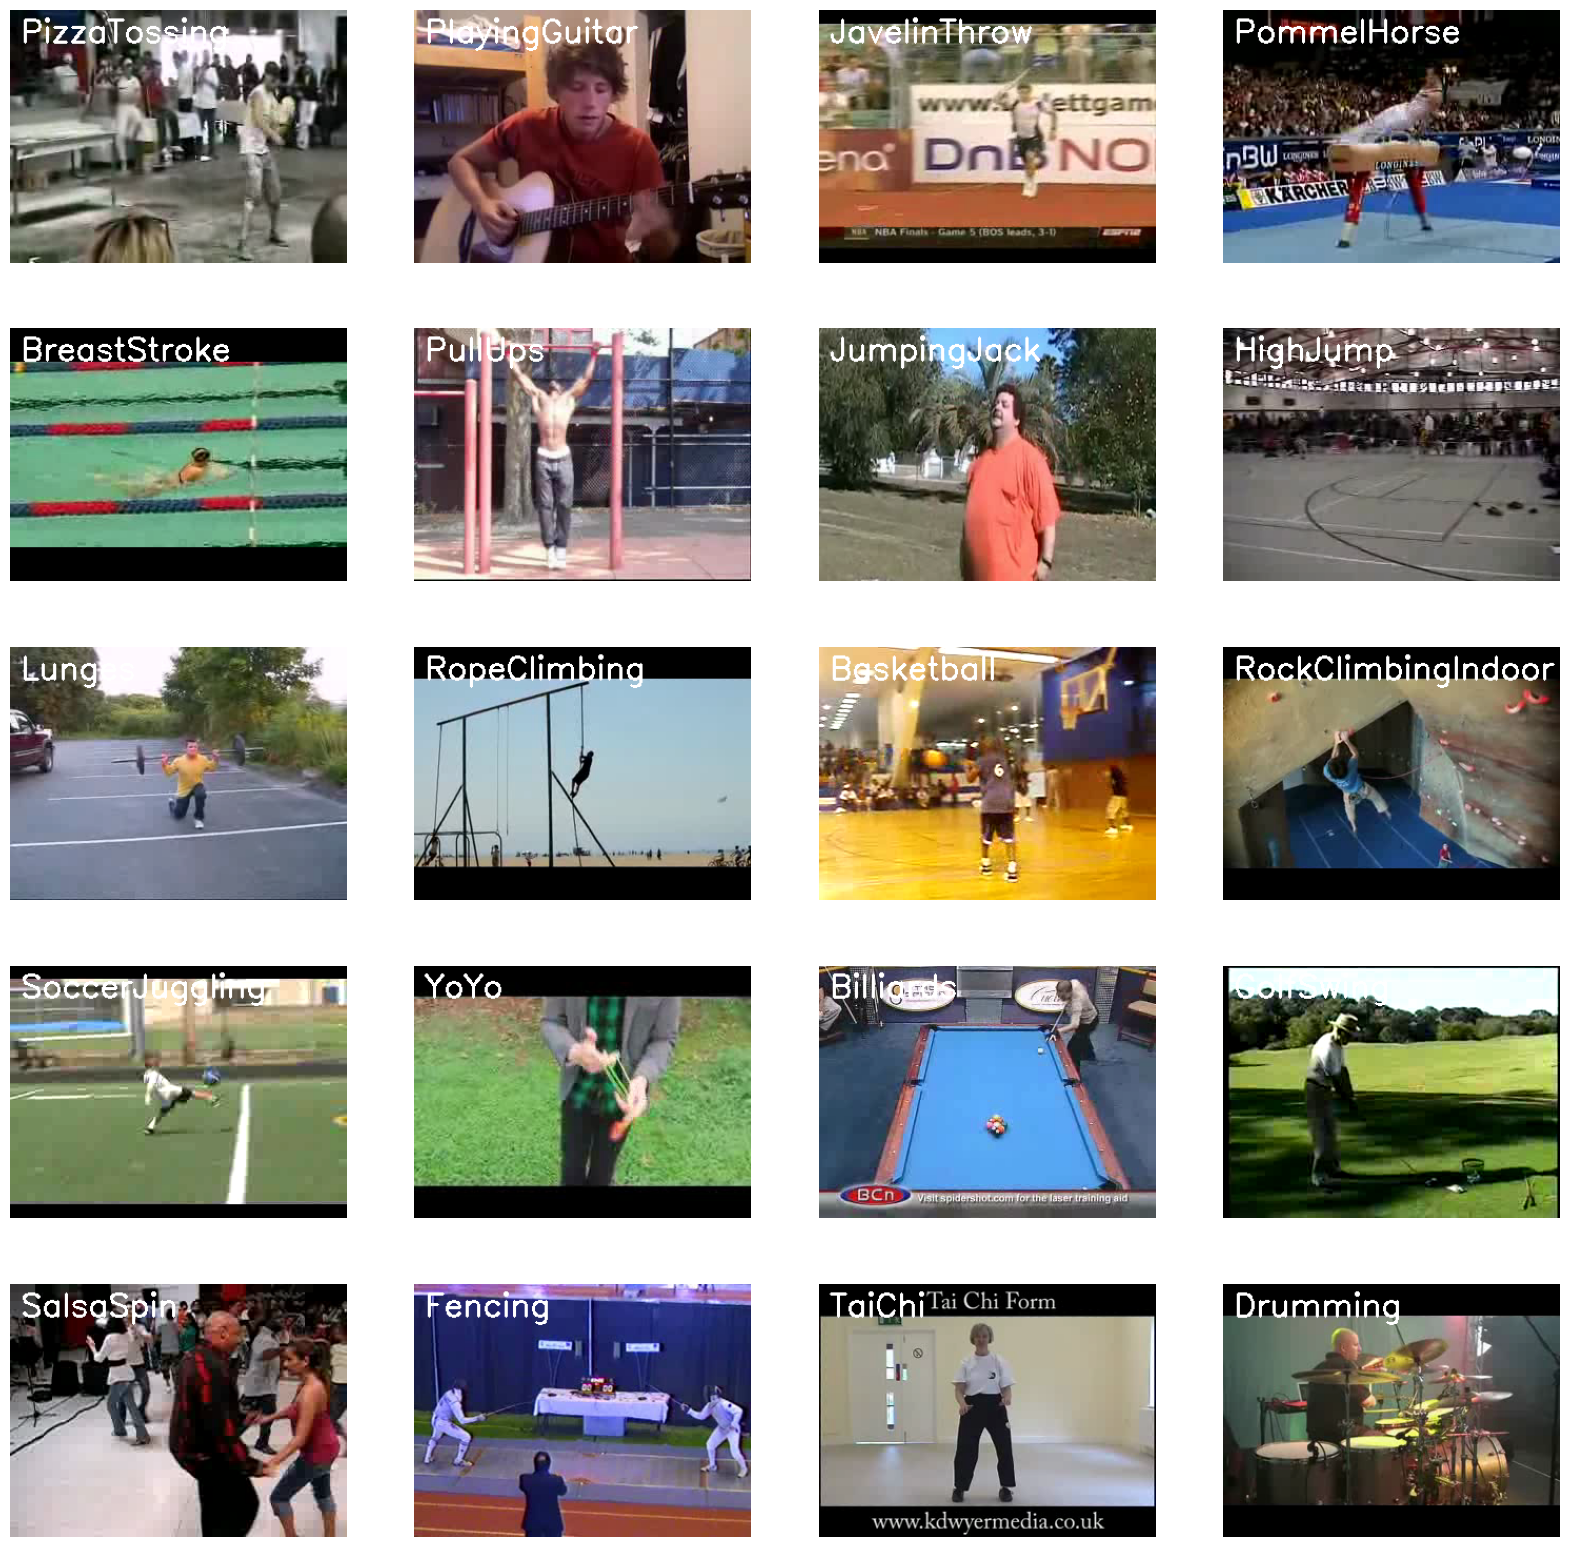

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in ../model/UCF50.
all_classes_names = os.listdir('../model/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'../model/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'../model/UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [3]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "../model/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Basketball","Rowing","Skiing","PlayingViolin","PullUps","Diving","Biking","BenchPress"]

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [11]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [4]:
features_train = np.load('../data/features_train.npy')
features_test = np.load('../data/features_test.npy')
labels_train = np.load('../data/labels_train.npy')
labels_test = np.load('../data/labels_test.npy')

 MODEL

In [90]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(128, name='LSTM', use_bias=False))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [95]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_97 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_98 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_99 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_100 (Time  (None, 20, 4, 4, 32)     

## Approximation

In [6]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code/main')
from iterative_approximation.Algorithm1 import *

import statistics

from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [7]:
lrcn = load_model('../model/LRCN_model128___Date_Time_2024_04_19__00_29_50___Loss_0.6276578903198242___Accuracy_0.8484848737716675.keras')

original_weight = lrcn.layers[-2].get_weights()

In [54]:
y_test = np.argmax(labels_test, axis=-1)
y_pred = np.argmax(lrcn(features_test), axis=1)
accuracy_baseline = accuracy_score(y_test, y_pred)

accuracy_baseline

0.8484848484848485

In [9]:
def extract_weight_array(layer):
    kernel, recurrent_kernel = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]


In [10]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel]
    
    layer.set_weights(approximated_weight)


In [114]:
def generate_pairs(R):
    # Define the possible values for Tc
    Tc_values = [2, 4, 8, 16, 32, 64, 128]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = R // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64, 128]:
                valid_pairs.append([Tc, NZc])


    # Return the list of valid pairs
    return valid_pairs

In [113]:
def generate_pairs2(C):
    # Define the possible values for Tc
    Tc_values = [2, 8, 16, 32, 64, 192]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = C // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64, 192]:
                valid_pairs.append([Tc, NZc])

    # Return the list of valid pairs
    return valid_pairs


In [115]:
R = 128
valid_pairs_R = generate_pairs(R)

C = 192
valid_pairs_C = generate_pairs2(C)

In [116]:
def roofline_model_baseline(clock_frequency,bandwidth,precision,N,R,C,Tr,Tc):
    Nops = N*(4*(R*C + R*(C-1)) + 24*R)

    Ncycles = max(R/Tr, C/Tc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    memory_footprint = N * 4 * (R * C) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [119]:
def design_space_exploration_baseline(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):

    valid_pairs_R = [2,4,8,16,32,64,128]
    valid_pairs_C = [2,4,8,16,32,64]

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_baseline(clock_frequency,bandwidth,32,1,R,C,pair_R,pair_C)
                        
            results.append({
                'Tr': pair_R,
                'Tc': pair_C,
                'Accuracy (%)': baseline_accuracy*100,
                'MSE': 0,
                'Nsteps': 'N/A',
                'Memory Footprint (byte)': 4*R*C*32,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })

    result = pd.DataFrame(results)

    return result


In [18]:
def roofline_model_single(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [19]:
def roofline_model_stack4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(Nsteps*(2*NZc*Tc + 1 + 8*NZr*Tr) + 24*R)

    Ncycles = max(4*Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [20]:
def roofline_model_group4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [21]:
def roofline_model_hybrid(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [22]:
def design_space_exploration_single(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    LSTM_layer = lrcn.layers[-2]
    LSTM_layer.set_weights(original_weight)

    W = extract_weight_array(lrcn.layers[-2])

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.iterative_approximation_step1()

                # Recalculate MSE for the new weights
                W_MSE = W1.average_mse_array()

                if W1.steps > 45:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_layer,original_weight,W1.current_reconstructed_weight_array)
                    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
                    accuracy = accuracy_score(y_test, y_pred)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_single(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': W1.average_mse_array(),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            LSTM_layer.set_weights(original_weight)

    result = pd.DataFrame(results)

    return result


In [23]:
def design_space_exploration_stack4(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    LSTM_layer = lrcn.layers[-2]
    LSTM_layer.set_weights(original_weight)

    W = extract_weight_array(lrcn.layers[-2])

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'weight', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1_approximated = W1.iterative_approximation_step3()

                # Recalculate MSE for the new weights
                W_MSE = W1.average_mse_weight()

                if W1.steps > 45:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_layer,original_weight,W1_approximated)
                    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
                    accuracy = accuracy_score(y_test, y_pred)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_stack4(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': W1.average_mse_weight(),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            LSTM_layer.set_weights(original_weight)

    result = pd.DataFrame(results)

    return result

In [24]:
def design_space_exploration_group4(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    LSTM_layer = lrcn.layers[-2]
    LSTM_layer.set_weights(original_weight)

    W = extract_weight_array(lrcn.layers[-2])

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            accuracy = 0.7
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.iterative_approximation_step2_norm('fro')

                # Recalculate MSE for the new weights
                W_MSE = W1.average_mse_array()

                if W1.steps > 60:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_layer,original_weight,W1.current_reconstructed_weight_array)
                    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
                    accuracy = accuracy_score(y_test, y_pred)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_group4(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': W1.average_mse_array(),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            LSTM_layer.set_weights(original_weight)

    result = pd.DataFrame(results)

    return result

In [25]:
def design_space_exploration_hybrid(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth,strategy):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    LSTM_layer = lrcn.layers[-2]
    LSTM_layer.set_weights(original_weight)

    W = extract_weight_array(lrcn.layers[-2])

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            accuracy = 0.7
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.hybrid_iterative_approximation_step(strategy)

                # Recalculate MSE for the new weights
                W_MSE = W1.average_mse_array()

                if W1.steps > 60:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_layer,original_weight,W1.current_reconstructed_weight_array)
                    y_pred = np.argmax(lrcn.predict(features_test),axis=1)
                    accuracy = accuracy_score(y_test, y_pred)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_hybrid(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': W1.average_mse_array(),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            LSTM_layer.set_weights(original_weight)

    result = pd.DataFrame(results)

    return result

In [53]:
clock_frequency = 400 # 400MHz
bandwidth = 10 # 10GB/s

In [121]:
baseline_10GB = design_space_exploration_baseline(accuracy_baseline,0.033484,0.006, clock_frequency, bandwidth)

In [ ]:
single_10GB = design_space_exploration_single(accuracy_baseline,0.033484,0.006, clock_frequency, bandwidth)

In [ ]:
stack4_10GB = design_space_exploration_stack4(accuracy_baseline,0.033484,0.006, clock_frequency, bandwidth)

13/13 [==============================] - 1s 53ms/step


In [ ]:
group4_10GB = design_space_exploration_group4(accuracy_baseline,0.033484,0.006, clock_frequency, bandwidth)

13/13 [==============================] - 1s 44ms/step


In [79]:
hybrid1_10GB = design_space_exploration_hybrid(accuracy_baseline,0.033484,0.006, clock_frequency, bandwidth,1)

13/13 [==============================] - 1s 50ms/step


In [80]:
hybrid3_10GB = design_space_exploration_hybrid(accuracy_baseline,0.033484,0.006, clock_frequency, bandwidth,3)

13/13 [==============================] - 1s 45ms/step


In [81]:
hybrid6_10GB = design_space_exploration_hybrid(accuracy_baseline,0.033484,0.006, clock_frequency, bandwidth,6)

13/13 [==============================] - 1s 47ms/step


In [40]:
def extract_result(name):

    # List to store all DataFrames
    dfs = []

    path = '/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/'

    # Loop through each file and load into a DataFrame
    for i in range(7):  # Assuming you have files named single_part_0.csv to single_part_6.csv
        filename = f"{path}{name}_part_{i}.csv"
        df = pd.read_csv(filename)
        dfs.append(df)

    # Concatenate all DataFrames into one
    combined_df = pd.concat(dfs, ignore_index=True)

    # Save the combined DataFrame to a new CSV file
    combined_df.to_csv(f"{path}{name}_10GB.csv", index=False)

    return dfs

In [20]:
def update_results(df, clock_frequency, bandwidth, computation_roof):
    # Define a helper function to apply to each row
    def update_row(row):
        # Calculate CP (Clock Performance)
        row['CP (GOps/s)'] = (row['Nops'] / row['Ncycles']) * clock_frequency/1000
        
        # Calculate Attainable Performance (AttPerf)
        row['AttPerf (GOps/s)'] = min(row['CTC (Ops/byte)'] * bandwidth, row['CP (GOps/s)'],computation_roof)
        
        # Calculate Execution Time (Texe)
        if row['AttPerf (GOps/s)'] != 0:  # Avoid division by zero
            row['Execution Time (s)'] = row['Nops'] / row['AttPerf (GOps/s)']/1000000000
        else:
            row['Execution Time (s)'] = float('inf')  # Handle division by zero as infinite time
        
        return row

    # Apply the function across the DataFrame
    df = df.apply(update_row, axis=1)
    return df

In [111]:
def cal_dsp_usage_baseline(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr']) +
                           adder_dsp * (result['Tc'] - 1)*result['Tr'] +
                           multiplier_dsp * result['Tc'] *result['Tr']) * 4
    return result

In [19]:
def cal_dsp_usage(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc']) * 4

    return result

In [45]:
def cal_dsp_usage_stack4(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc'])

    return result

In [55]:
def remove(df, accuracy_baseline, accuracy_loss):
    result = df.copy()

    # Calculate the accuracy threshold
    accuracy = accuracy_baseline*100 - accuracy_loss
    
    # Remove entries from the DataFrame where 'Accuracy (%)' is not greater than the calculated accuracy
    result = result[result['Accuracy (%)'] > accuracy]
    
    return result

In [42]:
extract_result('single')
extract_result('stack4')
extract_result('group4')
extract_result('hybrid1')
extract_result('hybrid3')
extract_result('hybrid6')

In [122]:
single_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Single_10GB.csv')
stack4_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Stack4_10GB.csv')
group4_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Group4_10GB.csv')
hybrid1_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Hybrid1_10GB.csv')
hybrid3_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Hybrid3_10GB.csv')
# hybrid6_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Hybrid6_10GB.csv')

In [125]:
baseline_10GB_dsp = cal_dsp_usage_baseline(baseline_10GB, 2, 2, 7)
single_10GB_dsp = cal_dsp_usage(single_10GB, 2, 2, 7)
stack4_10GB_dsp = cal_dsp_usage_stack4(stack4_10GB, 2, 2, 7)
group4_10GB_dsp = cal_dsp_usage(group4_10GB, 2, 2, 7)
hybrid1_10GB_dsp = cal_dsp_usage(hybrid1_10GB, 2, 2, 7)
hybrid3_10GB_dsp = cal_dsp_usage(hybrid3_10GB, 2, 2, 7)
# hybrid6_10GB_dsp = cal_dsp_usage(hybrid6_10GB, 2, 2, 7)

# remove entries that do not satisfy accuracy requirement
single_10GB_dsp = remove(single_10GB_dsp, accuracy_baseline,3.3484)
stack4_10GB_dsp = remove(stack4_10GB_dsp, accuracy_baseline,3.3484)
group4_10GB_dsp = remove(group4_10GB_dsp, accuracy_baseline,3.3484)
hybrid1_10GB_dsp = remove(hybrid1_10GB_dsp, accuracy_baseline,3.3484)
hybrid3_10GB_dsp = remove(hybrid3_10GB_dsp, accuracy_baseline,3.3484)
# hybrid6_10GB_dsp = remove(hybrid6_10GB_dsp, accuracy_baseline,3.3484)

single_10GB_dsp.to_csv('../dse_result1/single_10GB_dsp.csv', index=False)
stack4_10GB_dsp.to_csv('../dse_result1/stack4_10GB_dsp.csv', index=False)
group4_10GB_dsp.to_csv('../dse_result1/group4_10GB_dsp.csv', index=False)
hybrid1_10GB_dsp.to_csv('../dse_result1/hybrid1_10GB_dsp.csv', index=False)
hybrid3_10GB_dsp.to_csv('../dse_result1/hybrid3_10GB_dsp.csv', index=False)
# hybrid6_10GB_dsp.to_csv('../dse_result1/hybrid6_10GB_dsp.csv', index=False)

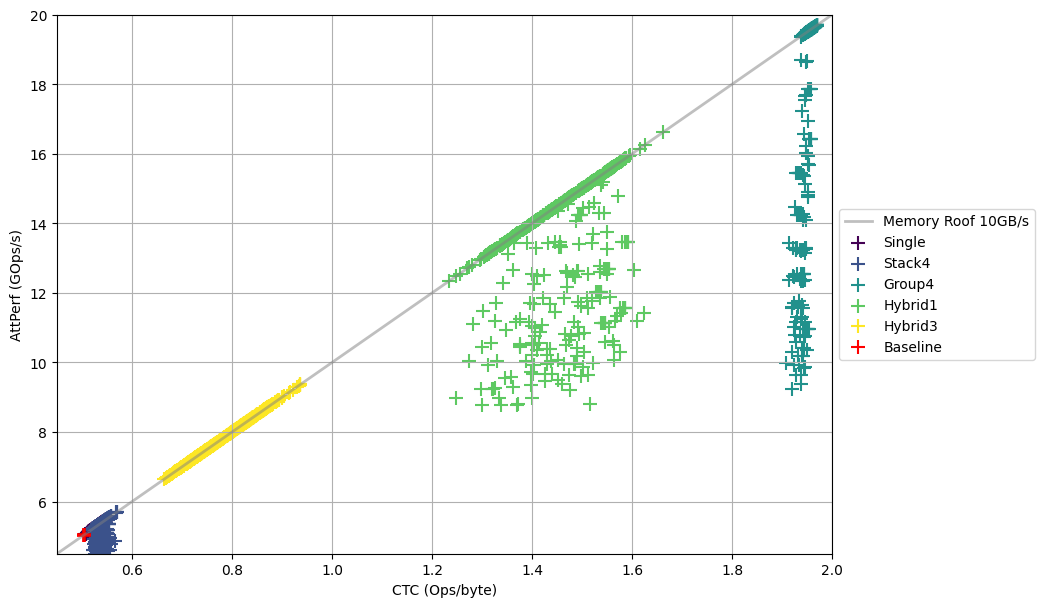

In [127]:
# Plotting
plt.figure(figsize=(10, 7))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.5, linewidth=2)

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

plt.scatter(baseline_10GB_dsp['CTC (Ops/byte)'], baseline_10GB_dsp['AttPerf (GOps/s)'],
            color='red', marker='+', s=100, label='Baseline')


# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
plt.xlim([0.45,2])
plt.ylim([4.5,20])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

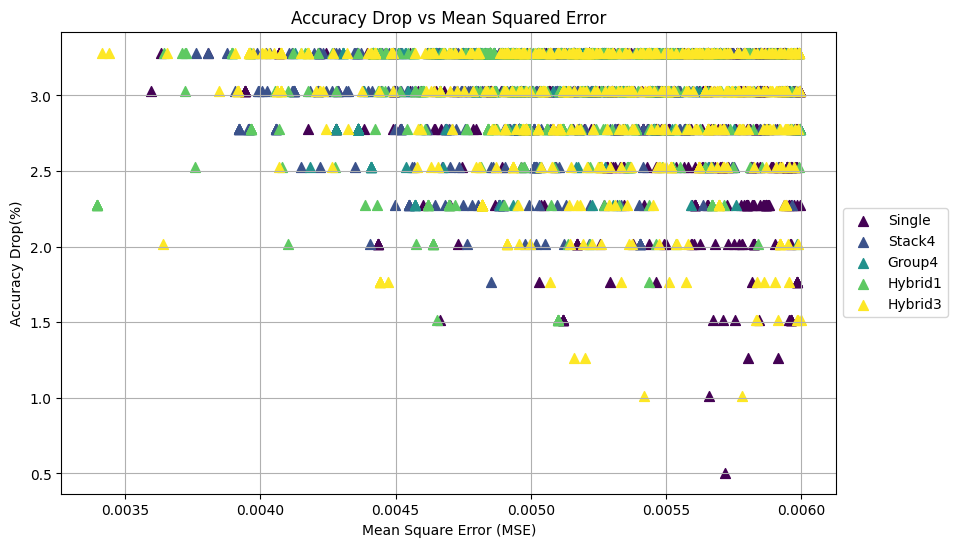

In [70]:
# Assuming you've already imported or defined stack4_10GB and single_10GB

# Plotting
plt.figure(figsize=(10, 6))


plt.scatter(single_10GB_dsp['MSE'], accuracy_baseline*100 - single_10GB_dsp['Accuracy (%)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_10GB_dsp['MSE'], accuracy_baseline*100 - stack4_10GB_dsp['Accuracy (%)'],
            color=colors[1], marker='^', s=50, label='Stack4')

plt.scatter(group4_10GB_dsp['MSE'], accuracy_baseline*100 - group4_10GB_dsp['Accuracy (%)'],
            color=colors[2], marker='^', s=50, label='Group4')

plt.scatter(hybrid1_10GB_dsp['MSE'], accuracy_baseline*100 - hybrid1_10GB_dsp['Accuracy (%)'],
            color=colors[3], marker='^', s=50, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['MSE'], accuracy_baseline*100 - hybrid3_10GB_dsp['Accuracy (%)'],
            color=colors[4], marker='^', s=50, label='Hybrid3')



# Labeling the axes
plt.title('Accuracy Drop vs Mean Squared Error')
plt.xlabel('Mean Square Error (MSE)')
plt.ylabel('Accuracy Drop(%)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()


# Show the plot
plt.show()

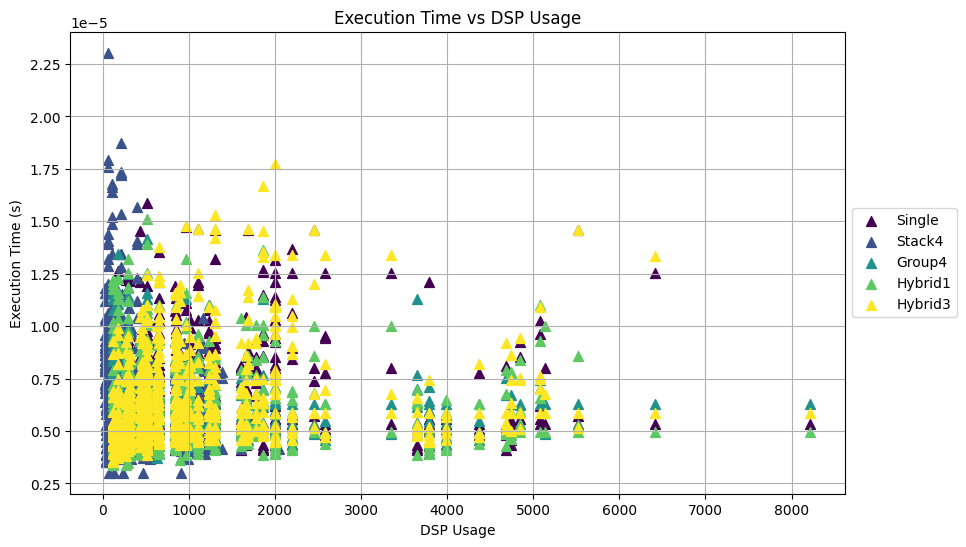

In [71]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['Execution Time (s)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=50, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['Execution Time (s)'],
            color=colors[2], marker='^', s=50, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['Execution Time (s)'],
            color=colors[3], marker='^', s=50, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['Execution Time (s)'],
            color=colors[4], marker='^', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

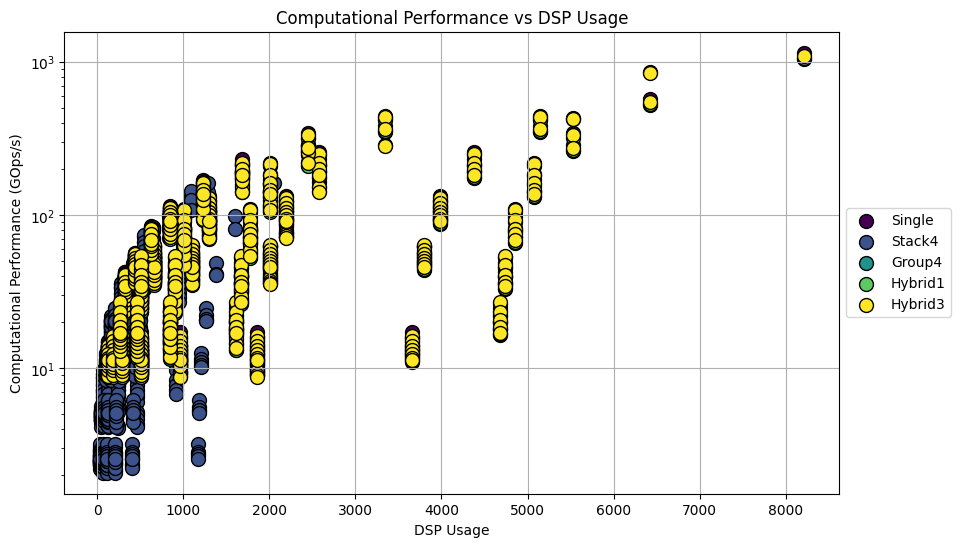

In [73]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['CP (GOps/s)'],
            color=colors[0], marker='o',edgecolors='black', s=100, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['CP (GOps/s)'],
            color=colors[1], marker='o',edgecolors='black', s=100, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['CP (GOps/s)'],
            color=colors[2], marker='o',edgecolors='black', s=100, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['CP (GOps/s)'],
            color=colors[3], marker='o',edgecolors='black', s=100, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['CP (GOps/s)'],
            color=colors[4], marker='o',edgecolors='black', s=100, label='Hybrid3')
            

# Labeling the axes
plt.title('Computational Performance vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Computational Performance (GOps/s)')

# Set y-axis to log scale
plt.yscale('log')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

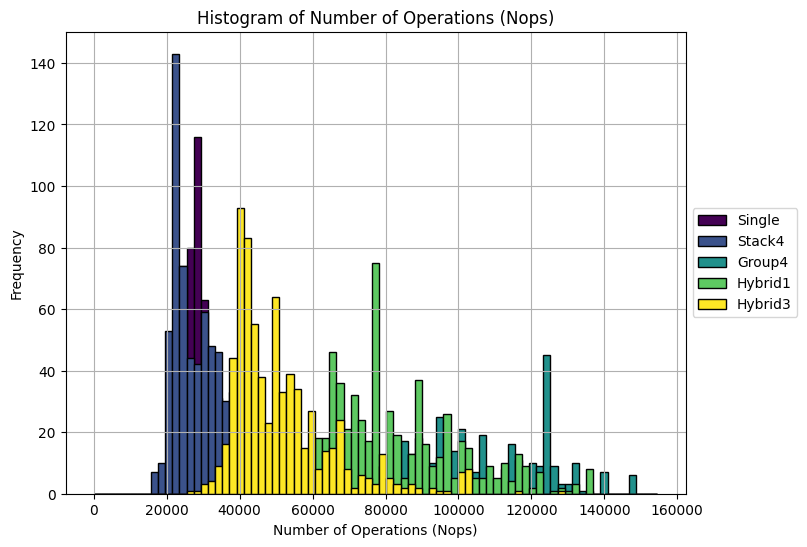

In [74]:
# Plotting the histogram
plt.figure(figsize=(8, 6))  # Set the figure size

colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Determine the maximum value among all datasets to set a reasonable bin size
max_value = max(
    single_10GB_dsp['Nops'].max(),
    stack4_10GB_dsp['Nops'].max(),
    group4_10GB_dsp['Nops'].max(),
    hybrid1_10GB_dsp['Nops'].max(),
    hybrid3_10GB_dsp['Nops'].max()
)

# Calculate a reasonable bin size based on the maximum value
bin_size = max_value / 80  # Adjust 30 to the desired number of bins

plt.hist(single_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[0], edgecolor='black',label='Single')
plt.hist(stack4_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[1], edgecolor='black',label='Stack4')
plt.hist(group4_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[2], edgecolor='black',label='Group4')
plt.hist(hybrid1_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[3], edgecolor='black',label='Hybrid1')
plt.hist(hybrid3_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[4], edgecolor='black',label='Hybrid3')

# Adding labels and title
plt.xlabel('Number of Operations (Nops)')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Operations (Nops)')

# Show the grid
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()

In [75]:
print(f"Single Nops Median: {single_10GB_dsp['Nops'].median()}")
print(f"Stack4 Nops Median: {stack4_10GB_dsp['Nops'].median()}")
print(f"Group4 Nops Median: {group4_10GB_dsp['Nops'].median()}")
print(f"Hybrid1 Nops Median: {hybrid1_10GB_dsp['Nops'].median()}")
print(f"Hybrid3 Nops Median: {hybrid3_10GB_dsp['Nops'].median()}")

Single Nops Median: 30008.0
Stack4 Nops Median: 27897.0
Group4 Nops Median: 107240.0
Hybrid1 Nops Median: 77428.0
Hybrid3 Nops Median: 47972.0


In [76]:
print(f"Single AttPerf (GOps/s) Median: {single_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Stack4 AttPerf (GOps/s) Median: {stack4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Group4 AttPerf (GOps/s) Median: {group4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid1 AttPerf (GOps/s) Median: {hybrid1_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid3 AttPerf (GOps/s) Median: {hybrid3_10GB_dsp['AttPerf (GOps/s)'].median()}")

Single AttPerf (GOps/s) Median: 5.337003222341568
Stack4 AttPerf (GOps/s) Median: 5.275166052759603
Group4 AttPerf (GOps/s) Median: 19.53715314986662
Hybrid1 AttPerf (GOps/s) Median: 14.198049272663399
Hybrid3 AttPerf (GOps/s) Median: 8.067908397226681


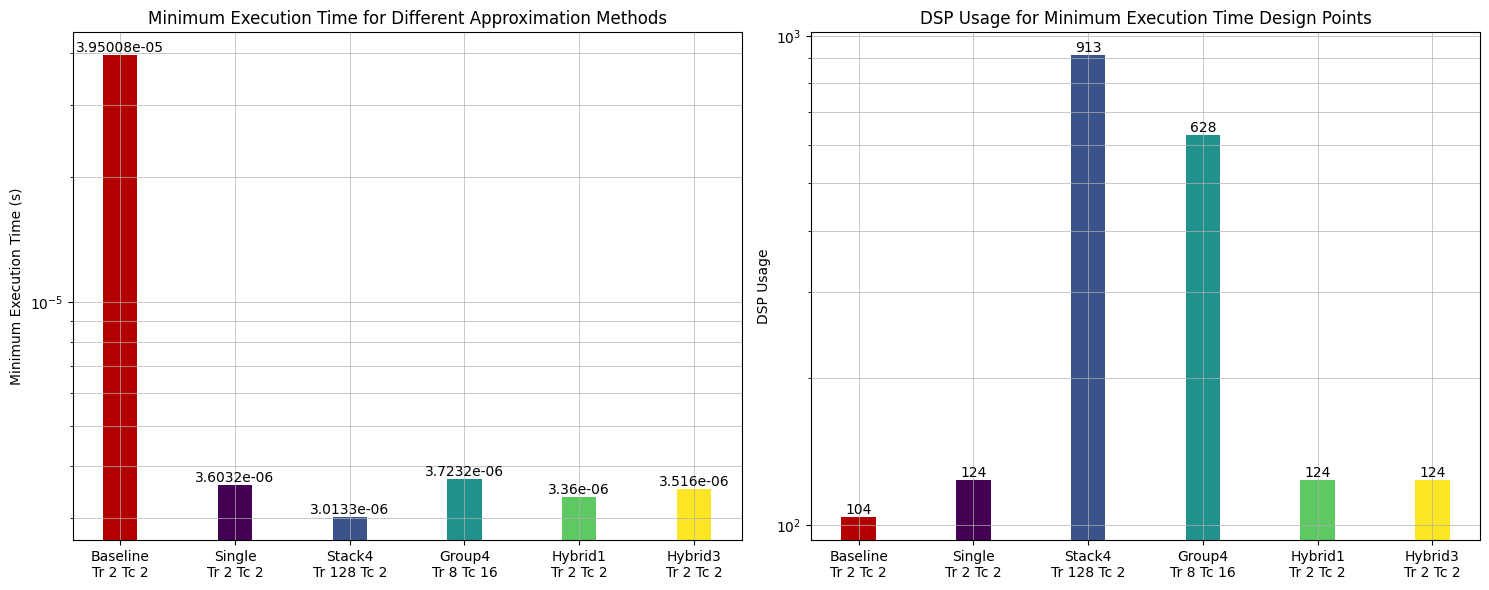

In [130]:
import matplotlib.ticker as ticker

baseline_10GB_min = baseline_10GB_dsp[baseline_10GB_dsp['Execution Time (s)'] == baseline_10GB_dsp['Execution Time (s)'].min()].iloc[0]
single_10GB_min = single_10GB_dsp[single_10GB_dsp['Execution Time (s)'] == single_10GB_dsp['Execution Time (s)'].min()]
stack4_10GB_min = stack4_10GB_dsp[stack4_10GB_dsp['Execution Time (s)'] == stack4_10GB_dsp['Execution Time (s)'].min()]
group4_10GB_min = group4_10GB_dsp[group4_10GB_dsp['Execution Time (s)'] == group4_10GB_dsp['Execution Time (s)'].min()]
hybrid1_10GB_min = hybrid1_10GB_dsp[hybrid1_10GB_dsp['Execution Time (s)'] == hybrid1_10GB_dsp['Execution Time (s)'].min()]
hybrid3_10GB_min = hybrid3_10GB_dsp[hybrid3_10GB_dsp['Execution Time (s)'] == hybrid3_10GB_dsp['Execution Time (s)'].min()]

# Prepare the DataFrame for Minimum Execution Time
df_min_values_time = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr']} Tc {baseline_10GB_min['Tc']}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'Min Execution Time (s)': [
        baseline_10GB_min['Execution Time (s)'],
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0],
        hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
})

# Prepare the DataFrame for DSP Usage
df_min_values_dsp = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr']} Tc {baseline_10GB_min['Tc']}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'DSP Usage': [
        baseline_10GB_min['DSP Usage'],
        single_10GB_min['DSP Usage'].iloc[0],
        stack4_10GB_min['DSP Usage'].iloc[0],
        group4_10GB_min['DSP Usage'].iloc[0],
        hybrid1_10GB_min['DSP Usage'].iloc[0],
        hybrid3_10GB_min['DSP Usage'].iloc[0]
    ]
})

# Plotting
plt.figure(figsize=(15, 6))  # Bigger figure to accommodate both subplots

# Subplot for Minimum Execution Time
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
colors = [list([0.7, 0, 0])]  # Red color in RGB
vir_colors = plt.cm.viridis(np.linspace(0, 1, 5))
colors.extend(vir_colors)  # Extend the list with viridis colors

bars_time = plt.bar(df_min_values_time['Dataset'], df_min_values_time['Min Execution Time (s)'], color=colors, width=0.3)
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')

plt.ylabel('Minimum Execution Time (s)')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.title('Minimum Execution Time for Different Approximation Methods')


# Subplot for DSP Usage
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
bars_dsp = plt.bar(df_min_values_dsp['Dataset'], df_min_values_dsp['DSP Usage'], color=colors, width=0.3)
for bar in bars_dsp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('DSP Usage')
plt.yscale('log')
# Setting the y-axis to have a minor grid with specific locations
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks

plt.title('DSP Usage for Minimum Execution Time Design Points')

plt.tight_layout()  # Adjust layout
plt.show()



In [158]:
baseline_10GB_min= baseline_10GB_dsp.nsmallest(100, 'Execution Time (s)').iloc[0]
single_10GB_min_5 = single_10GB_dsp.nsmallest(100, 'Execution Time (s)')
stack4_10GB_min_5 = stack4_10GB_dsp.nsmallest(100, 'Execution Time (s)')
group4_10GB_min_5 = group4_10GB_dsp.nsmallest(100, 'Execution Time (s)')
hybrid1_10GB_min_5 = hybrid1_10GB_dsp.nsmallest(100, 'Execution Time (s)')
hybrid3_10GB_min_5 = hybrid3_10GB_dsp.nsmallest(100, 'Execution Time (s)')

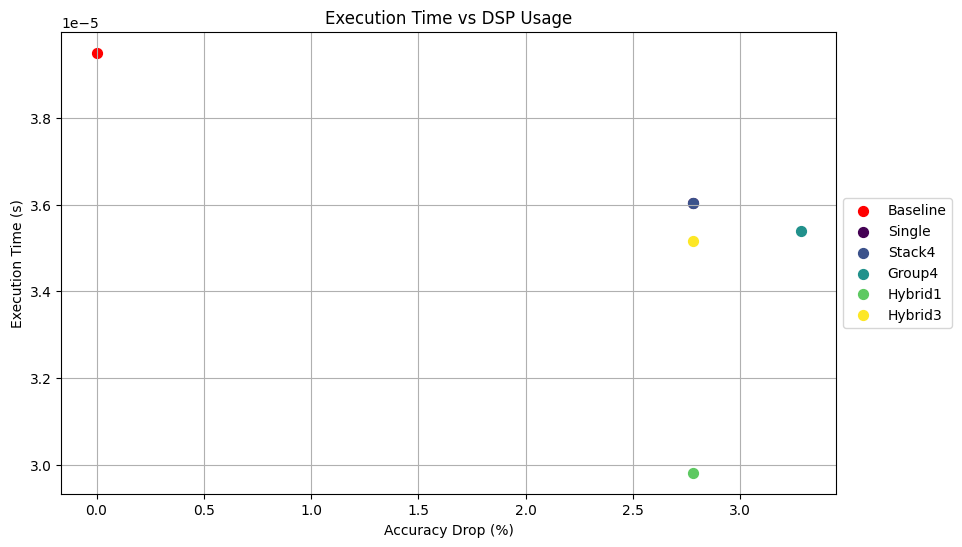

In [155]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(accuracy_baseline*100 - baseline_10GB_min['Accuracy (%)'], baseline_10GB_min['Execution Time (s)'],
            color='red', marker='o', s=50, label='Baseline')

plt.scatter(accuracy_baseline*100 - single_10GB_min_5['Accuracy (%)'], single_10GB_min_5['Execution Time (s)'],
            color=colors[0], marker='o', s=50, label='Single')

plt.scatter(accuracy_baseline*100 - stack4_10GB_min_5['Accuracy (%)'], stack4_10GB_min_5['Execution Time (s)'],
            color=colors[1], marker='o', s=50, label='Stack4')

plt.scatter(accuracy_baseline*100 - group4_10GB_min_5['Accuracy (%)'], group4_10GB_min_5['Execution Time (s)'],
            color=colors[2], marker='o', s=50, label='Group4')
            
plt.scatter(accuracy_baseline*100 - hybrid1_10GB_min_5['Accuracy (%)'], hybrid1_10GB_min_5['Execution Time (s)'],
            color=colors[3], marker='o', s=50, label='Hybrid1')

plt.scatter(accuracy_baseline*100 - hybrid3_10GB_min_5['Accuracy (%)'], hybrid3_10GB_min_5['Execution Time (s)'],
            color=colors[4], marker='o', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('Accuracy Drop (%)')
plt.ylabel('Execution Time (s)')
# Setting y-axis to logarithmic scale
plt.yscale('log')

# Setting minor locators for the y-axis
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))

# Setting minor locators for the x-axis
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Automatically determine the number of minor intervals

# Enabling grid for both major and minor ticks
plt.grid(True, which="both", linestyle='-', linewidth=0.5, axis='both')  # Enable grid on both axes

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [134]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
baseline_5GB = update_results(baseline_10GB_dsp,400,5,20)
single_5GB = update_results(single_10GB_dsp,400,5,20)
stack4_5GB = update_results(stack4_10GB_dsp,400,5,20)
group4_5GB = update_results(group4_10GB_dsp,400,5,20)
hybrid1_5GB = update_results(hybrid1_10GB_dsp,400,5,20)
hybrid3_5GB = update_results(hybrid3_10GB_dsp,400,5,20)

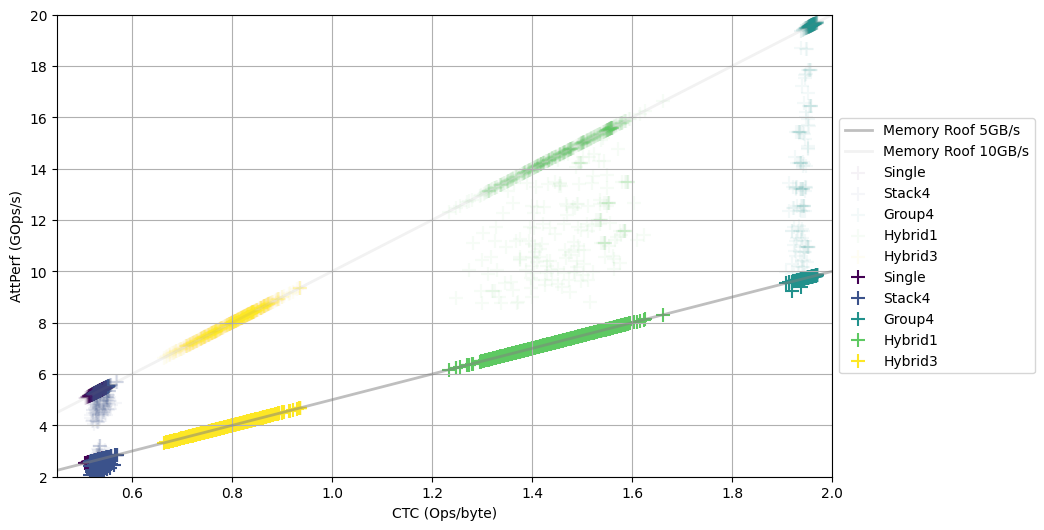

In [80]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 5 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 5GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_5GB['CTC (Ops/byte)'], single_5GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_5GB['CTC (Ops/byte)'], stack4_5GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_5GB['CTC (Ops/byte)'], group4_5GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_5GB['CTC (Ops/byte)'], hybrid1_5GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_5GB['CTC (Ops/byte)'], hybrid3_5GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
plt.ylim([2,20])
plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

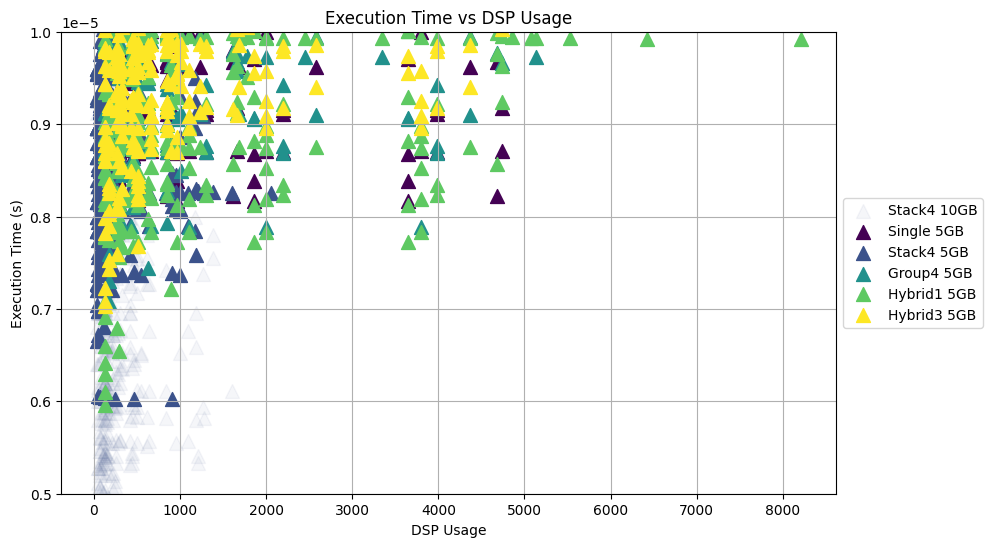

In [88]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.05)

plt.scatter(single_5GB['DSP Usage'], single_5GB['Execution Time (s)'],
            color=colors[0], marker='^', s=100, label='Single 5GB')
plt.scatter(stack4_5GB['DSP Usage'], stack4_5GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 5GB')
plt.scatter(group4_5GB['DSP Usage'], group4_5GB['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 5GB')
plt.scatter(hybrid1_5GB['DSP Usage'], hybrid1_5GB['Execution Time (s)'],
            color=colors[3], marker='^', s=100, label='Hybrid1 5GB')
plt.scatter(hybrid3_5GB['DSP Usage'], hybrid3_5GB['Execution Time (s)'],
            color=colors[4], marker='^', s=100, label='Hybrid3 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

plt.ylim([0.000005,0.00001])

# Show the plot
plt.show()

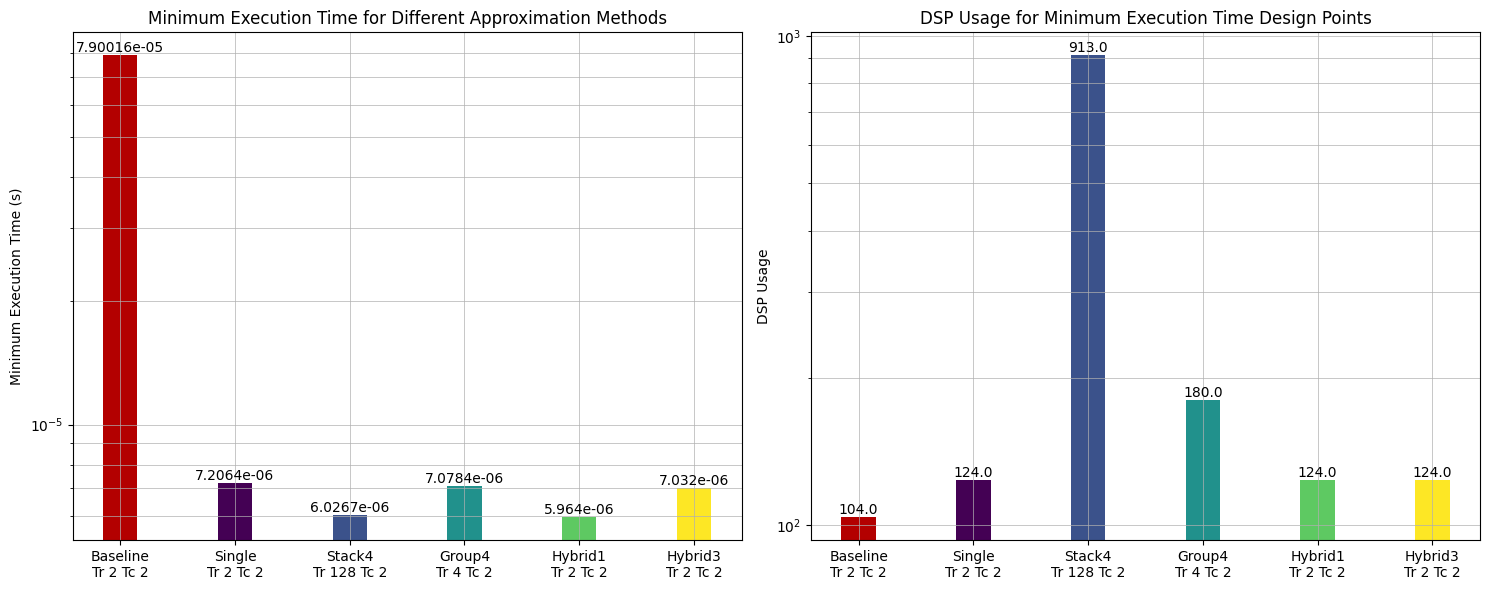

In [136]:
import matplotlib.ticker as ticker

baseline_10GB_min = baseline_5GB[baseline_5GB['Execution Time (s)'] == baseline_5GB['Execution Time (s)'].min()].iloc[0]
single_10GB_min = single_5GB[single_5GB['Execution Time (s)'] == single_5GB['Execution Time (s)'].min()]
stack4_10GB_min = stack4_5GB[stack4_5GB['Execution Time (s)'] == stack4_5GB['Execution Time (s)'].min()]
group4_10GB_min = group4_5GB[group4_5GB['Execution Time (s)'] == group4_5GB['Execution Time (s)'].min()]
hybrid1_10GB_min = hybrid1_5GB[hybrid1_5GB['Execution Time (s)'] == hybrid1_5GB['Execution Time (s)'].min()]
hybrid3_10GB_min = hybrid3_5GB[hybrid3_5GB['Execution Time (s)'] == hybrid3_5GB['Execution Time (s)'].min()]

# Prepare the DataFrame for Minimum Execution Time
df_min_values_time = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {int(baseline_10GB_min['Tr'])} Tc {int(baseline_10GB_min['Tc'])}",
        f"Single\nTr {int(single_10GB_min['Tr'].iloc[0])} Tc {int(single_10GB_min['Tc'].iloc[0])}",
        f"Stack4\nTr {int(stack4_10GB_min['Tr'].iloc[0])} Tc {int(stack4_10GB_min['Tc'].iloc[0])}",
        f"Group4\nTr {int(group4_10GB_min['Tr'].iloc[0])} Tc {int(group4_10GB_min['Tc'].iloc[0])}",
        f"Hybrid1\nTr {int(hybrid1_10GB_min['Tr'].iloc[0])} Tc {int(hybrid1_10GB_min['Tc'].iloc[0])}",
        f"Hybrid3\nTr {int(hybrid3_10GB_min['Tr'].iloc[0])} Tc {int(hybrid3_10GB_min['Tc'].iloc[0])}"
    ],
    'Min Execution Time (s)': [
        baseline_10GB_min['Execution Time (s)'],
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0],
        hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
})

# Prepare the DataFrame for DSP Usage
df_min_values_dsp = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {int(baseline_10GB_min['Tr'])} Tc {int(baseline_10GB_min['Tc'])}",
        f"Single\nTr {int(single_10GB_min['Tr'].iloc[0])} Tc {int(single_10GB_min['Tc'].iloc[0])}",
        f"Stack4\nTr {int(stack4_10GB_min['Tr'].iloc[0])} Tc {int(stack4_10GB_min['Tc'].iloc[0])}",
        f"Group4\nTr {int(group4_10GB_min['Tr'].iloc[0])} Tc {int(group4_10GB_min['Tc'].iloc[0])}",
        f"Hybrid1\nTr {int(hybrid1_10GB_min['Tr'].iloc[0])} Tc {int(hybrid1_10GB_min['Tc'].iloc[0])}",
        f"Hybrid3\nTr {int(hybrid3_10GB_min['Tr'].iloc[0])} Tc {int(hybrid3_10GB_min['Tc'].iloc[0])}"
    ],
    'DSP Usage': [
        baseline_10GB_min['DSP Usage'],
        single_10GB_min['DSP Usage'].iloc[0],
        stack4_10GB_min['DSP Usage'].iloc[0],
        group4_10GB_min['DSP Usage'].iloc[0],
        hybrid1_10GB_min['DSP Usage'].iloc[0],
        hybrid3_10GB_min['DSP Usage'].iloc[0]
    ]
})

# Plotting
plt.figure(figsize=(15, 6))  # Bigger figure to accommodate both subplots

# Subplot for Minimum Execution Time
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
colors = [list([0.7, 0, 0])]  # Red color in RGB
vir_colors = plt.cm.viridis(np.linspace(0, 1, 5))
colors.extend(vir_colors)  # Extend the list with viridis colors

bars_time = plt.bar(df_min_values_time['Dataset'], df_min_values_time['Min Execution Time (s)'], color=colors, width=0.3)
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')

plt.ylabel('Minimum Execution Time (s)')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.title('Minimum Execution Time for Different Approximation Methods')


# Subplot for DSP Usage
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
bars_dsp = plt.bar(df_min_values_dsp['Dataset'], df_min_values_dsp['DSP Usage'], color=colors, width=0.3)
for bar in bars_dsp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('DSP Usage')
plt.yscale('log')
# Setting the y-axis to have a minor grid with specific locations
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks

plt.title('DSP Usage for Minimum Execution Time Design Points')

plt.tight_layout()  # Adjust layout
plt.show()



In [89]:
single_20GB = update_results(single_10GB_dsp,400,20,50)
stack4_20GB = update_results(stack4_10GB_dsp,400,20,50)
group4_20GB = update_results(group4_10GB_dsp,400,20,50)
hybrid1_20GB = update_results(hybrid1_10GB_dsp,400,20,50)
hybrid3_20GB = update_results(hybrid3_10GB_dsp,400,20,50)

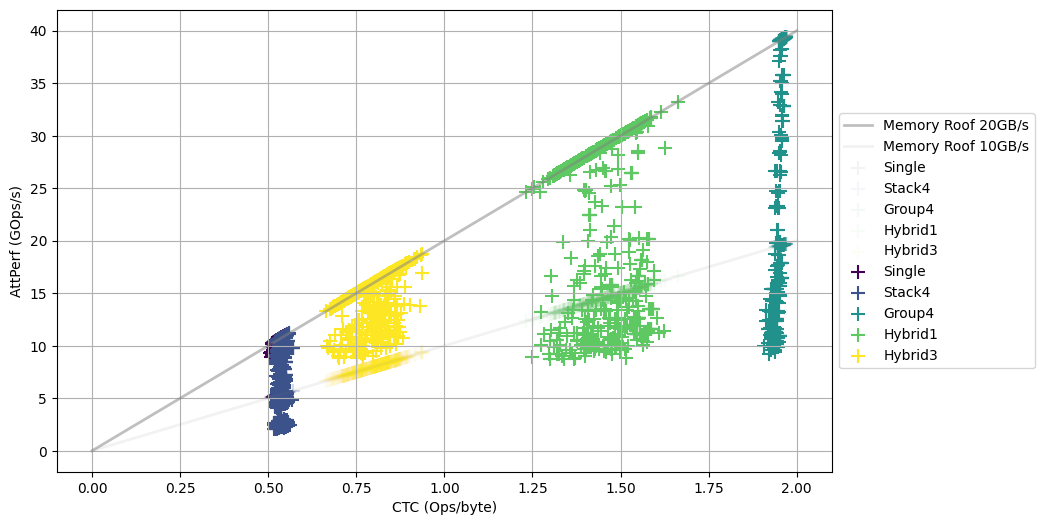

In [92]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 20 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 20GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_20GB['CTC (Ops/byte)'], single_20GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_20GB['CTC (Ops/byte)'], stack4_20GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_20GB['CTC (Ops/byte)'], group4_20GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_20GB['CTC (Ops/byte)'], hybrid1_20GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_20GB['CTC (Ops/byte)'], hybrid3_20GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.ylim([2,20])
# plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

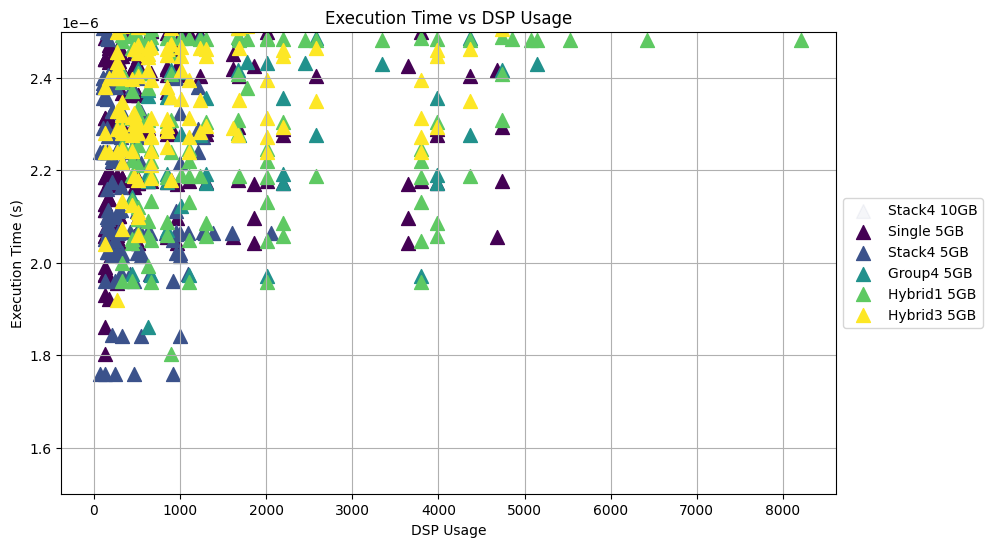

In [98]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.05)

plt.scatter(single_20GB['DSP Usage'], single_20GB['Execution Time (s)'],
            color=colors[0], marker='^', s=100, label='Single 5GB')
plt.scatter(stack4_20GB['DSP Usage'], stack4_20GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 5GB')
plt.scatter(group4_20GB['DSP Usage'], group4_20GB['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 5GB')
plt.scatter(hybrid1_20GB['DSP Usage'], hybrid1_20GB['Execution Time (s)'],
            color=colors[3], marker='^', s=100, label='Hybrid1 5GB')
plt.scatter(hybrid3_20GB['DSP Usage'], hybrid3_20GB['Execution Time (s)'],
            color=colors[4], marker='^', s=100, label='Hybrid3 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

plt.ylim([0.0000015,0.0000025])

# Show the plot
plt.show()

In [106]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
single_40GB = update_results(single_10GB_dsp,400,40,100)
stack4_40GB = update_results(stack4_10GB_dsp,400,40,100)
group4_40GB = update_results(group4_10GB_dsp,400,40,100)
hybrid1_40GB = update_results(hybrid1_10GB_dsp,400,40,100)
hybrid3_40GB = update_results(hybrid3_10GB_dsp,400,40,100)

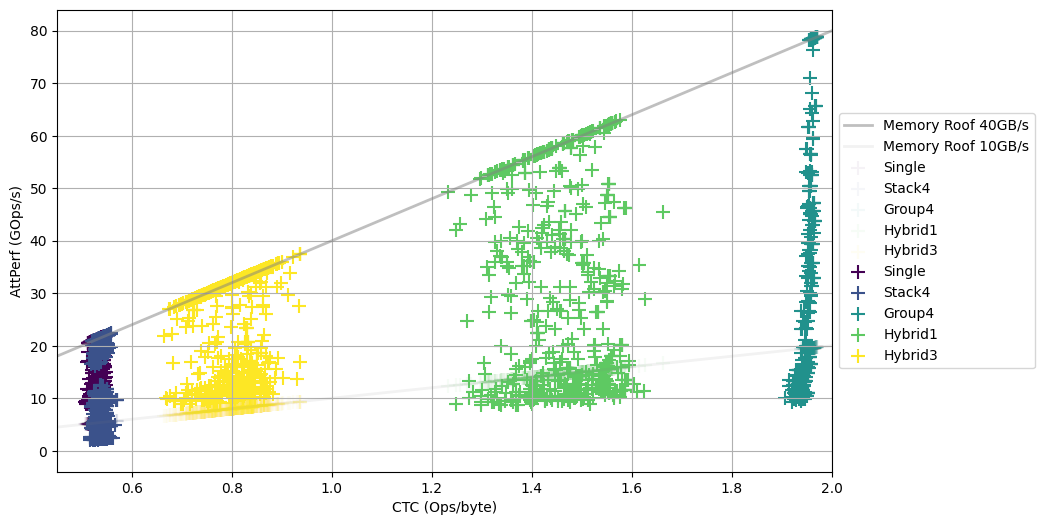

In [108]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 40 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 40GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_40GB['CTC (Ops/byte)'], single_40GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_40GB['CTC (Ops/byte)'], stack4_40GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_40GB['CTC (Ops/byte)'], group4_40GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_40GB['CTC (Ops/byte)'], hybrid1_40GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_40GB['CTC (Ops/byte)'], hybrid3_40GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.ylim([2,20])
plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

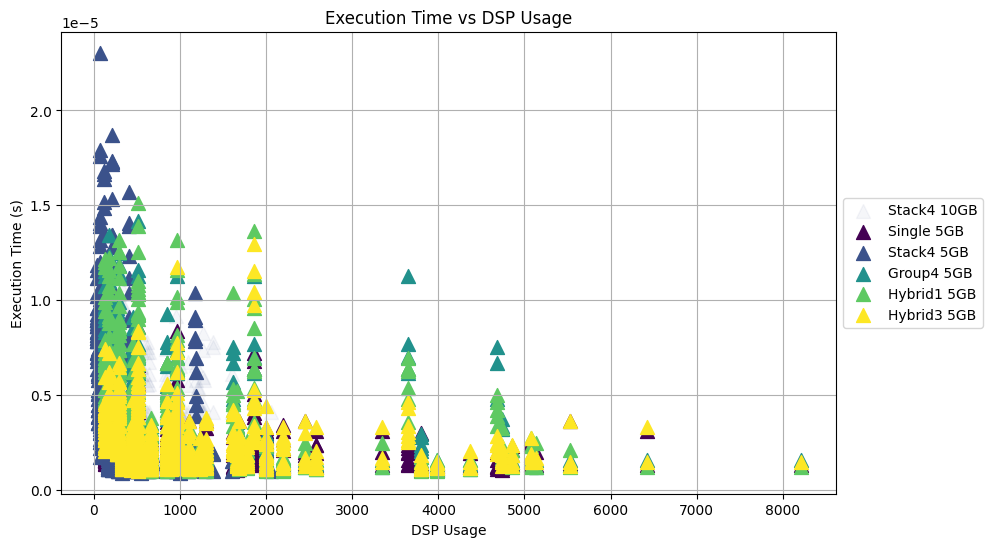

In [109]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.05)

plt.scatter(single_40GB['DSP Usage'], single_40GB['Execution Time (s)'],
            color=colors[0], marker='^', s=100, label='Single 5GB')
plt.scatter(stack4_40GB['DSP Usage'], stack4_40GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 5GB')
plt.scatter(group4_40GB['DSP Usage'], group4_40GB['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 5GB')
plt.scatter(hybrid1_40GB['DSP Usage'], hybrid1_40GB['Execution Time (s)'],
            color=colors[3], marker='^', s=100, label='Hybrid1 5GB')
plt.scatter(hybrid3_40GB['DSP Usage'], hybrid3_40GB['Execution Time (s)'],
            color=colors[4], marker='^', s=100, label='Hybrid3 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()